# FBXL4
[encephalomyopathic mitochondrial DNA depletion syndrome-13 (MTDPS13)](https://omim.org/entry/615471) is caused by homozygous mutation in the FBXL4 gene. Mitochondrial DNA depletion syndrome-13 is an autosomal recessive disorder characterized by early infantile onset of encephalopathy, hypotonia, lactic acidosis, and severe global developmental delay.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.7.1


# FBXL4
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for FBXL4.

In [3]:
gene_symbol = 'FBXL4'
mane_tx_id = 'NM_001278716.2'
mane_protein_id = 'NP_001265645.1' # F-box/LRR-repeat protein 4

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.21") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f"Extracted {len(phenopackets)} phenopackets for {gene_symbol}")


cohort_creator = configure_caching_cohort_creator(hpo)

"""
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
"""
from gpsea.preprocessing import load_phenopacket_folder
fbxl4_dir = "../../../phenopacket-store/notebooks/FBXL4/phenopackets"
cohort, validation = load_phenopacket_folder(fbxl4_dir, cohort_creator)

validation.summarize()

Extracted 95 phenopackets for FBXL4
Individuals Processed: 95individuals [00:01, 47.68individuals/s] 
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Increased serum lactate,HP:0002151,92
Hypotonia,HP:0001252,79
Global developmental delay,HP:0001263,52
Global brain atrophy,HP:0002283,39
Feeding difficulties,HP:0011968,36
Failure to thrive,HP:0001508,32
Cerebral atrophy,HP:0002059,30
Small for gestational age,HP:0001518,28
Short stature,HP:0004322,27
Microcephaly,HP:0000252,27


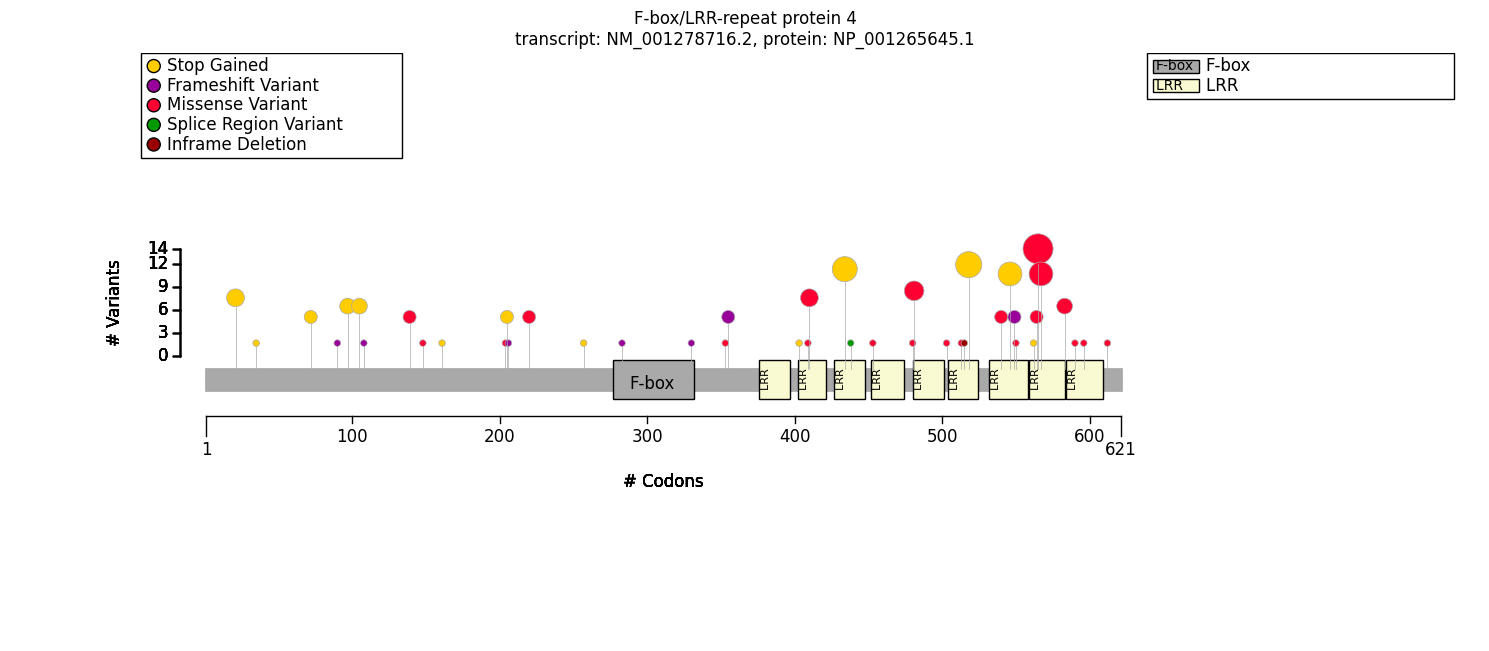

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

fbxl4_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fbxl4_fig.tight_layout()

In [7]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
6_98875419_98875419_T_C,c.1698A>G,p.Ile566Met,9,missense,14
6_98875562_98875562_G_A,c.1555C>T,p.Gln519Ter,9,stop gained,10
6_98874441_98874441_C_G,c.1703G>C,p.Gly568Ala,10,"missense, splice region",8
6_98875474_98875476_TCA_T,c.1641_1642del,p.Cys547Ter,9,"stop gained, frameshift",8
6_98899282_98899282_G_A,c.1303C>T,p.Arg435Ter,7,stop gained,6
6_98875673_98875673_G_A,c.1444C>T,p.Arg482Trp,9,missense,5
6_98899353_98899353_C_T,c.1232G>A,p.Cys411Tyr,7,missense,4
6_98926925_98926925_G_A,c.64C>T,p.Arg22Ter,4,stop gained,4
6_98926697_98926697_G_A,c.292C>T,p.Arg98Ter,4,stop gained,3
6_98926673_98926673_G_A,c.316C>T,p.Gln106Ter,4,stop gained,3


In [8]:
from gpsea.view import ProteinVariantViewer
pvviewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvviewer.process(cohort=cohort)

Name,Type,Coordinates,Count,Variants
F-box,DOMAIN,277 - 332,2,p.Leu332ThrfsTer3; p.Pro284LeufsTer7
LRR 1,REPEAT,376 - 397,0,
LRR 2,REPEAT,402 - 421,6,p.Cys411Tyr; p.Ser410Phe; p.Gln404Ter
LRR 3,REPEAT,427 - 448,10,p.Arg435Gln; p.Arg435Leu; p.Glu439=; p.Arg435Ter
LRR 4,REPEAT,452 - 474,1,p.Gln454Pro
LRR 5,REPEAT,480 - 501,6,p.Leu481Pro; p.Arg482Trp
LRR 6,REPEAT,504 - 524,12,p.Gln519Ter; p.Pro516_Ser521del; p.Trp514Gly
LRR 7,REPEAT,532 - 558,13,p.Cys547Ter; p.Asp550HisfsTer2; p.Ile551Asn; p.Thr541Ile
LRR 8,REPEAT,559 - 583,25,p.Gln563Ter; p.Gly568Ala; p.Asp565Gly; p.Ile566Met
LRR 9,REPEAT,584 - 609,2,p.Gln597Pro; p.Asp591Gly


# Genotype Phenotype Correlation (GPC) Analysis


In [9]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [16]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import biallelic_predicate, VariantPredicates

missense = VariantPredicates.variant_effect(effect=VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_predicate = biallelic_predicate(a_predicate=missense, 
                                  b_predicate=~missense,
                                  a_label="missense", 
                                  b_label="other",
                                  partitions=((1,2), (0,)))


In [ ]:
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,38
HMF03,Skipping term because of a child term with the same individual counts,4
HMF08,Skipping general term,88
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,201


In [12]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense/other OR other/other  ...          
                                                                           Count  ...  p values
Feeding difficulties [HP:0011968]                                          23/24  ...  0.000173
Cryptorchidism [HP:0000028]                                                 7/16  ...  0.031903
Microcephaly [HP:0000252]                                                  20/34  ...  0.034168
Short stature [HP:0004322]                                                 18/28  ...  0.055613
Failure to thrive [HP:0001508]                                             21/30  ...  0.061266
Ventriculomegaly [HP:0002119]                                              12/28  ...  0.087521
Hyperammonemia [HP:0001987]                                                12/31  ...  0.278061
Decreased body weight [HP:0004325]                                         28/28  ...  1.000000
Morphological central nervous system abnormalit...                         48/48  ...  1.000000
Abnormal cerebral morphology [HP:0002060]                                  27/27  ...  1.000000
Abnormal brain morphology [HP:0012443]                                     43/43  ...  1.000000
Global brain atrophy [HP:0002283]                                          22/22  ...  1.000000
Brain atrophy [HP:0012444]                                                 35/35  ...  1.000000
Aplasia/Hypoplasia involving the central nervou...                         39/39  ...  1.000000
Cerebral atrophy [HP:0002059]                                              17/31  ...  1.000000
Hypotonia [HP:0001252]                                                     45/48  ...  1.000000
Abnormal muscle tone [HP:0003808]                                          45/45  ...  1.000000
Small for gestational age [HP:0001518]                                     17/27  ...  1.000000
Increased serum lactate [HP:0002151]                                       54/54  ...  1.000000
Acidosis [HP:0001941]                                                      55/55  ...  1.000000
Global developmental delay [HP:0001263]                                    28/28  ...  1.000000
Abnormal axial skeleton morphology [HP:0009121]                            26/26  ...  1.000000

[22 rows x 6 columns]

In [19]:
from gpsea.model.genome import Region

nterm = VariantPredicates.region(region=Region(start=1, end=400), tx_id=mane_tx_id)

nterm_predicate = biallelic_predicate(a_predicate=nterm, b_predicate=~nterm,a_label="N-term", b_label="other",
                                  partitions=((0,1), (2,)))

In [20]:
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=nterm_predicate,
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group                                       N-term/N-term OR N-term/other  ...          
                                                                           Count  ...  p values
Cryptorchidism [HP:0000028]                                                  6/8  ...  0.001098
Feeding difficulties [HP:0011968]                                          16/16  ...  0.001909
Neutropenia [HP:0001875]                                                    8/19  ...  0.004269
Bilateral tonic-clonic seizure with generalized...                          5/12  ...  0.022434
Strabismus [HP:0000486]                                                     6/14  ...  0.049513
Cerebral atrophy [HP:0002059]                                              12/18  ...  0.252736
Hypotonia [HP:0001252]                                                     24/24  ...  0.314980
Ventriculomegaly [HP:0002119]                                               7/16  ...  0.336957
Hyperammonemia [HP:0001987]                                                 6/16  ...  0.553845
Short stature [HP:0004322]                                                 11/19  ...  0.569405
Small for gestational age [HP:0001518]                                      9/15  ...  0.750679
Failure to thrive [HP:0001508]                                             10/18  ...  1.000000
Decreased body weight [HP:0004325]                                         14/14  ...  1.000000
Morphological central nervous system abnormalit...                         24/24  ...  1.000000
Abnormal cerebral morphology [HP:0002060]                                  16/16  ...  1.000000
Abnormal brain morphology [HP:0012443]                                     22/22  ...  1.000000
Global brain atrophy [HP:0002283]                                          10/10  ...  1.000000
Brain atrophy [HP:0012444]                                                 19/19  ...  1.000000
Aplasia/Hypoplasia involving the central nervou...                         20/20  ...  1.000000
Abnormal muscle tone [HP:0003808]                                          24/24  ...  1.000000
Increased serum lactate [HP:0002151]                                       28/28  ...  1.000000
Acidosis [HP:0001941]                                                      28/28  ...  1.000000
Global developmental delay [HP:0001263]                                    16/16  ...  1.000000
Microcephaly [HP:0000252]                                                   9/20  ...  1.000000
Abnormal axial skeleton morphology [HP:0009121]                            15/15  ...  1.000000

[25 rows x 6 columns]

In [24]:
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)

from gpsea.analysis.temporal.endpoint import death

endpoint = death()
survival_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=missense_predicate,
    endpoint=endpoint,
)

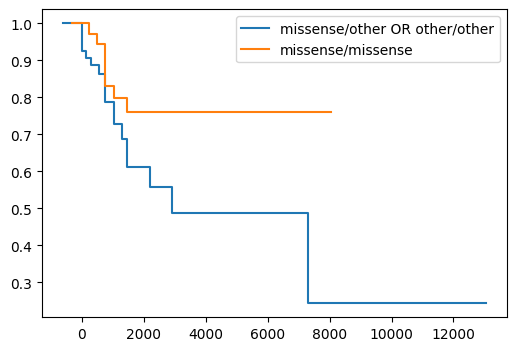

In [26]:
_, ax = plt.subplots(figsize=(6, 4))
survival_result.plot_kaplan_meier_curves(ax=ax)